### **CHURN ANALYSİS**
In this jupyter notebook we wil do some analysis on https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers which has 10k bank customers with;

 credit score, geography, gender, account details

*   credit score
*   geography
*   gender
*   account details

On later project we will use this dataset for predicting churn from customer using random forest

# 1-) **İmport the libaries**

The libaries we need are as follows;

*   numpy
*   pandas
*   seabron
*   Standart Scaler
*   Matplotlib



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 2-) **First look Into Dataset**


Now we will read and look at our datasets first rows and we will look at our datasets shape.Lastly we will check if our dataset has any missing values.

In [6]:
df=pd.read_csv('/content/Churn_Modelling.csv')
#First 5 rows of our dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
#Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [8]:
#Shape of our dataset
print("Dataset Shape:", df.shape)

Dataset Shape: (10000, 14)


# 3-)**Basic Preprocessing and first look into churn value**

In this part we will start preprocessing for churn analysis we;

1.   Create a copy of our dataset
2.   Remove any useless columns and check the columns we need
3.   Convert categorical variables(Gender and Geography)
4.   Scale the numerical values

After this we will look into our pre processed data and look our churn rate

In [10]:
# Basic preprocessing
def preprocess_bank_data(df):
    # Create a copy
    df_clean = df.copy()

    # Verify required columns exist
    required_columns = ['Geography', 'Gender', 'CreditScore', 'Age', 'Tenure',
                       'Balance', 'NumOfProducts', 'EstimatedSalary']
    missing_cols = [col for col in required_columns if col not in df_clean.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")


    # Convert categorical variables
    geography_dummies = pd.get_dummies(df_clean['Geography'], prefix='Geography')
    df_clean = df_clean.drop('Geography', axis=1)
    df_clean = pd.concat([df_clean, geography_dummies], axis=1)

    # Convert Gender with error handling
    gender_map = {'Female': 0, 'Male': 1}
    if not df_clean['Gender'].isin(gender_map.keys()).all():
        raise ValueError("Unknown gender categories found in data")
    df_clean['Gender'] = df_clean['Gender'].map(gender_map)

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                     'NumOfProducts', 'EstimatedSalary']
    df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

    return df_clean

# Preprocess the data
df_processed = preprocess_bank_data(df)

# Basic statistics
print("\nBasic statistics:")
print(df_processed.describe())

# Calculate churn rate
churn_rate = (df_processed['Exited'].sum() / len(df_processed)) * 100
print(f"\nOverall Churn Rate: {churn_rate:.2f}%")


Basic statistics:
         RowNumber    CustomerId   CreditScore        Gender           Age  \
count  10000.00000  1.000000e+04  1.000000e+04  10000.000000  1.000000e+04   
mean    5000.50000  1.569094e+07 -4.824585e-16      0.545700  2.318146e-16   
std     2886.89568  7.193619e+04  1.000050e+00      0.497932  1.000050e+00   
min        1.00000  1.556570e+07 -3.109504e+00      0.000000 -1.994969e+00   
25%     2500.75000  1.562853e+07 -6.883586e-01      0.000000 -6.600185e-01   
50%     5000.50000  1.569074e+07  1.522218e-02      1.000000 -1.832505e-01   
75%     7500.25000  1.575323e+07  6.981094e-01      1.000000  4.842246e-01   
max    10000.00000  1.581569e+07  2.063884e+00      1.000000  5.061197e+00   

             Tenure       Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count  1.000000e+04  1.000000e+04   1.000000e+04  10000.00000    10000.000000   
mean  -1.078249e-16 -6.252776e-17   1.634248e-17      0.70550        0.515100   
std    1.000050e+00  1.000050e+00  

# 4-)  **Segmenting Our Data For Better Analysis**

In this part we will segment our data based on;

1.   Age
2.   Balance
3.   Credit Score

Doing this will help us in our future graphs and analysis as we along the way while segmenting we will also look for errors and warning and create solutions for that

In [11]:
def analyze_customer_segments(df):
    """Analyze customer segments based on key characteristics"""

    # Create a copy of the dataframe
    df_segments = df.copy()


    # Age segments
    df_segments['AgeGroup'] = pd.cut(df['Age'],
                                    bins=[0, 30, 40, 50, 60, 100],
                                    labels=['<30', '30-40', '40-50', '50-60', '>60'])

    # Balance segments - handle unique bins and duplicates
    balance_values = df['Balance'].sort_values().unique()
    if len(balance_values) >= 4:
        quantiles = [0, 0.25, 0.5, 0.75, 1.0]
        balance_bins = [df['Balance'].quantile(q) for q in quantiles]
        # Ensure bins are unique
        balance_bins = sorted(list(set(balance_bins)))
        if len(balance_bins) >= 2:
            df_segments['BalanceGroup'] = pd.cut(df['Balance'],
                                               bins=balance_bins,
                                               labels=['Low', 'Medium', 'High', 'Very High'][:len(balance_bins)-1],
                                               duplicates='drop')
        else:
            # If not enough unique bins, create binary segmentation
            df_segments['BalanceGroup'] = pd.qcut(df['Balance'],
                                                q=2,
                                                labels=['Low', 'High'],
                                                duplicates='drop')
    else:
        # For very few unique values
        df_segments['BalanceGroup'] = pd.qcut(df['Balance'],
                                            q=2,
                                            labels=['Low', 'High'],
                                            duplicates='drop')

    # Credit score segments
    df_segments['CreditScoreGroup'] = pd.qcut(df['CreditScore'],
                                             q=3,
                                             labels=['Low', 'Medium', 'High'],
                                             duplicates='drop')

    return df_segments

# 5-)**Applying our segmentation to our churn analysis**

In this section we will calculate churns for the segments we do at 4th section and also in this part we will handle the system warning for getting better outputs

In [12]:
def create_churn_analysis(df):
    """Calculate churn rates for different segments"""

    analysis = {}

    # Add observed=True to suppress the warning
    analysis['age_churn'] = df.groupby('AgeGroup', observed=True)['Exited'].mean()
    analysis['balance_churn'] = df.groupby('BalanceGroup', observed=True)['Exited'].mean()
    analysis['credit_churn'] = df.groupby('CreditScoreGroup', observed=True)['Exited'].mean()
    analysis['products_churn'] = df.groupby('NumOfProducts', observed=True)['Exited'].mean()

    return analysis

def calculate_customer_value(df):
    """Calculate customer value metrics"""

    df['CustomerValue'] = df['Balance'] * df['Tenure'] / 12  # Annual value
    df['ChurnRisk'] = (df['Balance'] == 0).astype(int) + \
                      (df['NumOfProducts'] == 1).astype(int) + \
                      (df['IsActiveMember'] == 0).astype(int)

    return df

# 6-)Start our analysis

In this section we will look into our analysis results

In [13]:
# After preprocessing, add these lines:
# Perform customer segmentation and analysis
df_segmented = analyze_customer_segments(df)
churn_analysis = create_churn_analysis(df_segmented)
df_with_value = calculate_customer_value(df_segmented)


In [14]:
# Print analysis results
print("\nChurn Rate by Age Group:")
print(churn_analysis['age_churn'])

print("\nChurn Rate by Balance Group:")
print(churn_analysis['balance_churn'])

print("\nChurn Rate by Credit Score Group:")
print(churn_analysis['credit_churn'])

print("\nChurn Rate by Number of Products:")
print(churn_analysis['products_churn'])



Churn Rate by Age Group:
AgeGroup
<30      0.075203
30-40    0.120872
40-50    0.339655
50-60    0.562108
>60      0.247845
Name: Exited, dtype: float64

Churn Rate by Balance Group:
BalanceGroup
Low       0.208243
Medium    0.262800
High      0.236800
Name: Exited, dtype: float64

Churn Rate by Credit Score Group:
CreditScoreGroup
Low       0.215284
Medium    0.197660
High      0.198002
Name: Exited, dtype: float64

Churn Rate by Number of Products:
NumOfProducts
1    0.277144
2    0.075817
3    0.827068
4    1.000000
Name: Exited, dtype: float64


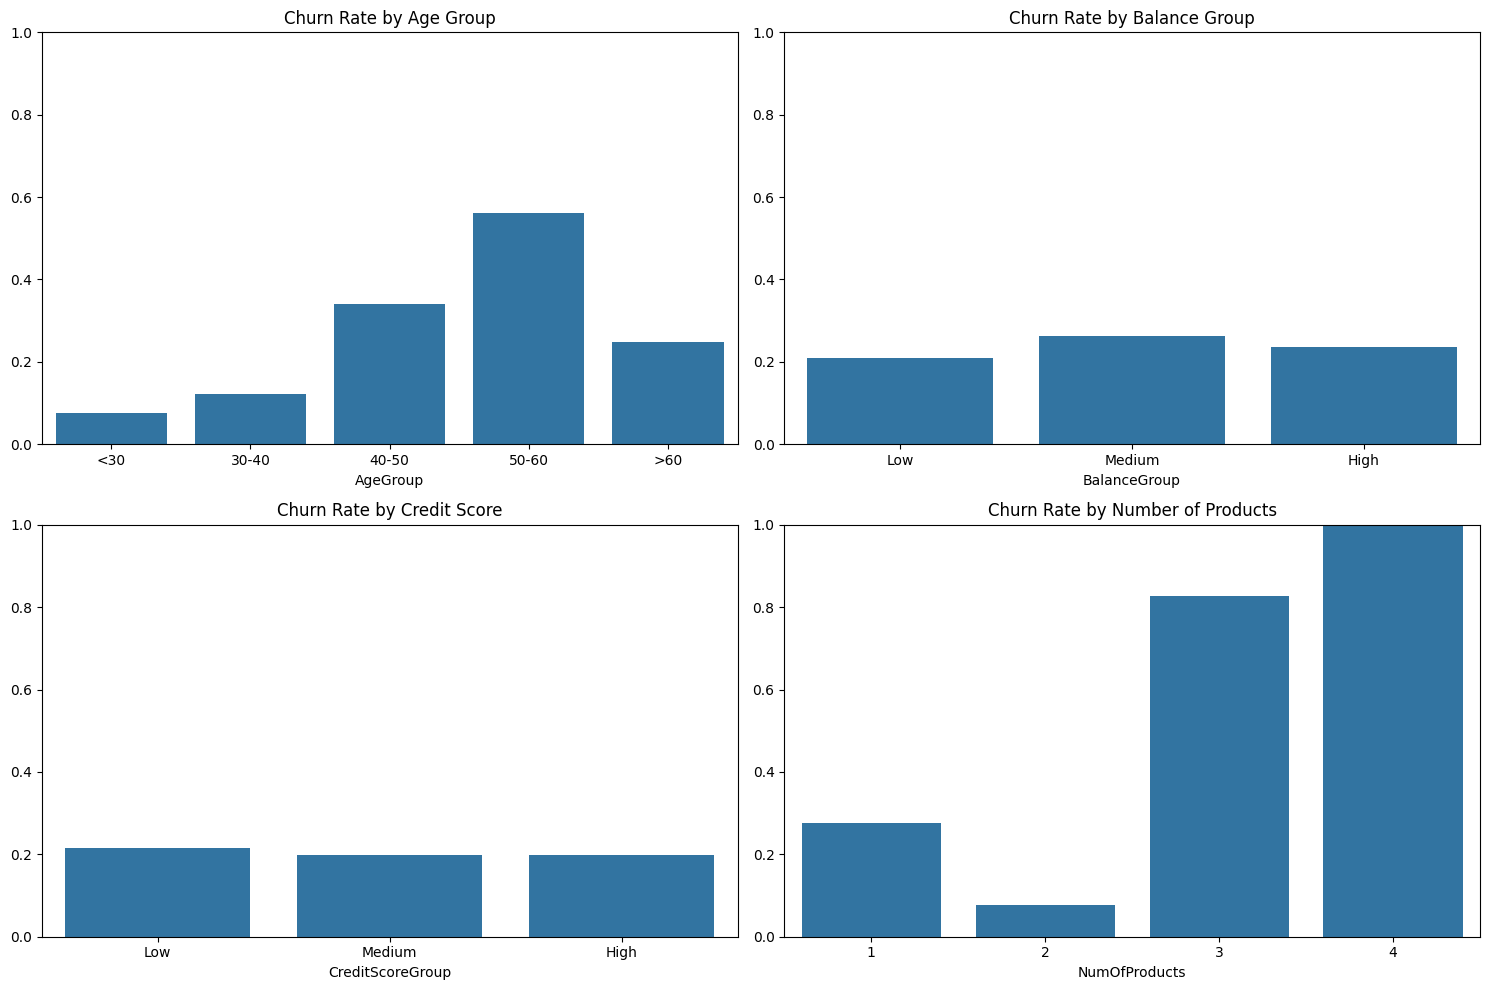

In [15]:
# Visualize the analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age Group Analysis
sns.barplot(x=churn_analysis['age_churn'].index,
            y=churn_analysis['age_churn'].values,
            ax=axes[0,0])
axes[0,0].set_title('Churn Rate by Age Group')
axes[0,0].set_ylim(0, 1)

# Balance Group Analysis
sns.barplot(x=churn_analysis['balance_churn'].index,
            y=churn_analysis['balance_churn'].values,
            ax=axes[0,1])
axes[0,1].set_title('Churn Rate by Balance Group')
axes[0,1].set_ylim(0, 1)

# Credit Score Analysis
sns.barplot(x=churn_analysis['credit_churn'].index,
            y=churn_analysis['credit_churn'].values,
            ax=axes[1,0])
axes[1,0].set_title('Churn Rate by Credit Score')
axes[1,0].set_ylim(0, 1)

# Number of Products Analysis
sns.barplot(x=churn_analysis['products_churn'].index,
            y=churn_analysis['products_churn'].values,
            ax=axes[1,1])
axes[1,1].set_title('Churn Rate by Number of Products')
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 7-)More graphs for better understanding of our dataset

In this section we will visualize more graphs for deepening our understanding of dataset


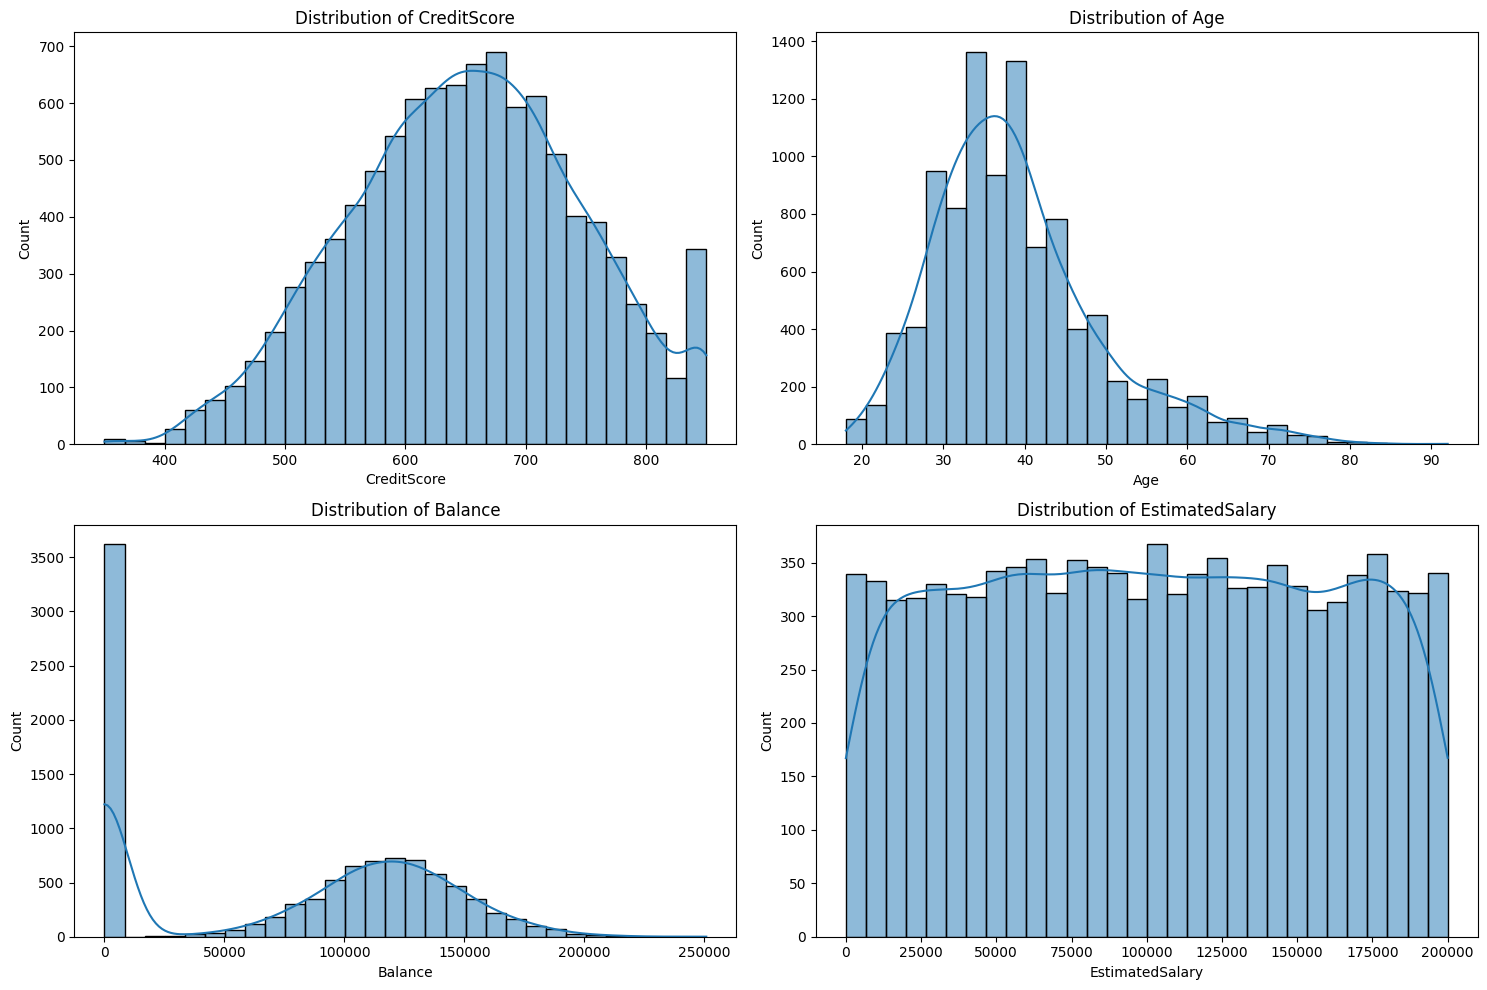

In [17]:
# Plot distributions of numerical features
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

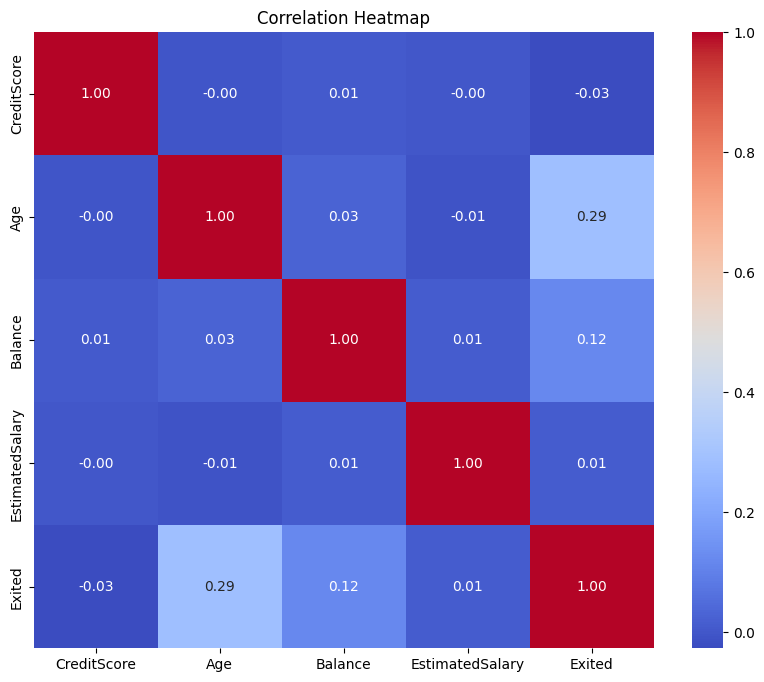

In [18]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols + ['Exited']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

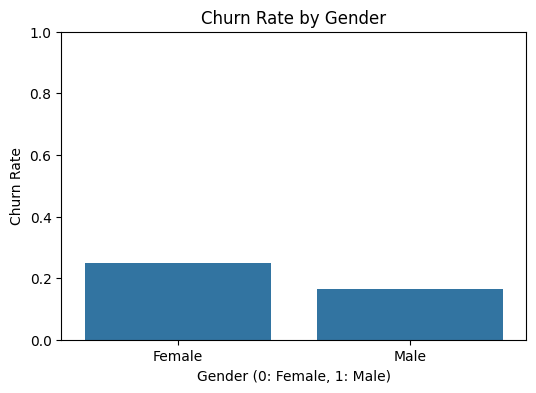

In [19]:
# Churn rate by gender
gender_churn = df.groupby('Gender')['Exited'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_churn.index, y=gender_churn.values)
plt.title('Churn Rate by Gender')
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()

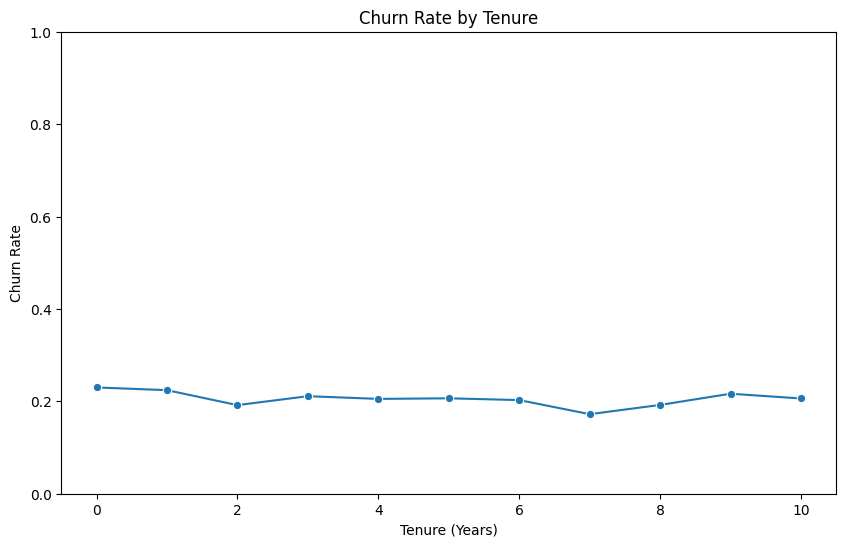

In [20]:
# Churn rate by tenure
tenure_churn = df.groupby('Tenure')['Exited'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=tenure_churn.index, y=tenure_churn.values, marker='o')
plt.title('Churn Rate by Tenure')
plt.xlabel('Tenure (Years)')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()

<ipython-input-23-c4155049e7a4>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_churn = df_with_value.groupby('CustomerValueGroup')['Exited'].mean()


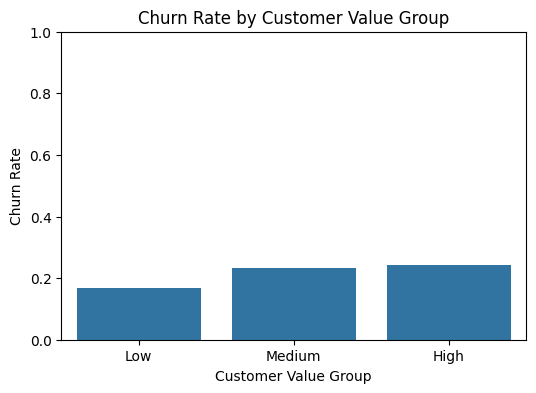

In [23]:
# Churn rate by customer value
df_with_value['CustomerValueGroup'] = pd.qcut(
    df_with_value['CustomerValue'],
    q=4,
    labels=False,  # Remove labels or reduce the number of labels
    duplicates='drop'
)
# If you want to add labels, adjust based on the number of unique bins:
num_bins = len(df_with_value['CustomerValueGroup'].unique())
bin_labels = ['Low', 'Medium', 'High', 'Very High'][:num_bins] # Updated line
df_with_value['CustomerValueGroup'] = pd.qcut(
    df_with_value['CustomerValue'],
    q=4,
    labels=bin_labels,  # Use adjusted labels
    duplicates='drop'
)
value_churn = df_with_value.groupby('CustomerValueGroup')['Exited'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=value_churn.index, y=value_churn.values)
plt.title('Churn Rate by Customer Value Group')
plt.xlabel('Customer Value Group')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()

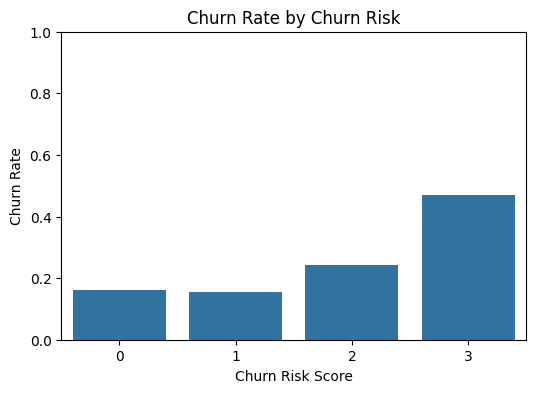

In [24]:
# Churn rate by churn risk
risk_churn = df_with_value.groupby('ChurnRisk')['Exited'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=risk_churn.index, y=risk_churn.values)
plt.title('Churn Rate by Churn Risk')
plt.xlabel('Churn Risk Score')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()